# EB5002 Text Processing

# Base Models

Code adapted from <https://www.kaggle.com/alvations/gru-language-model>

## Set the working directory

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'EB5002-TextProcessing'))
os.getcwd()

'/home/tkokkeng/Documents/EB5002-TextProcessing'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/python/python367/ptvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/ptvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/ptvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '',
 '/home/tkokkeng/python/python367/ptvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/.local/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython',
 '/home/tkokkeng/Documents/EB5002-TextProcessing/source']

In [3]:
# IPython candies...
from IPython.display import Image
from IPython.core.display import HTML

from IPython.display import clear_output

In [4]:
from collections import namedtuple
import numpy as np
from tqdm import tqdm
import pandas as pd
import json

from gensim.corpora import Dictionary

import torch
from torch import nn, optim, tensor, autograd
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12, 8)})

torch.manual_seed(42)

In [6]:
try: # Use the default NLTK tokenizer.
    from nltk import word_tokenize, sent_tokenize 
    # Testing whether it works. 
    # Sometimes it doesn't work on some machines because of setup issues.
    word_tokenize(sent_tokenize("This is a foobar sentence. Yes it is.")[0])
except: # Use a naive sentence tokenizer and toktok.
    import re
    from nltk.tokenize import ToktokTokenizer
    # See https://stackoverflow.com/a/25736515/610569
    sent_tokenize = lambda x: re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', x)
    # Use the toktok tokenizer that requires no dependencies.
    toktok = ToktokTokenizer()
    word_tokenize = word_tokenize = toktok.tokenize

In [7]:
# import os
# import requests
import io #codecs

# Text version of https://kilgarriff.co.uk/Publications/2005-K-lineer.pdf
# if os.path.isfile('language-never-random.txt'):
#     with io.open('language-never-random.txt', encoding='utf8') as fin:
#         text = fin.read()
# else:
#     url = "https://gist.githubusercontent.com/alvations/53b01e4076573fea47c6057120bb017a/raw/b01ff96a5f76848450e648f35da6497ca9454e4a/language-never-random.txt"
#     text = requests.get(url).content.decode('utf8')
#     with io.open('language-never-random.txt', 'w', encoding='utf8') as fout:
#         fout.write(text)

## Load data

In [8]:
# Tokenize the text.
# tokenized_text = [list(map(str.lower, word_tokenize(sent))) 
#                   for sent in sent_tokenize(text)]

with io.open(os.path.join('data', 'tokenised-tweets.txt'), encoding='utf8') as infile:
    tokenized_text = json.load(infile)

In [9]:
len(tokenized_text)

9236

In [10]:
tokenized_text[0]

['the',
 'question',
 'in',
 'this',
 'election',
 ':',
 'who',
 'can',
 'put',
 'the',
 'plans',
 'into',
 'action',
 'that',
 'will',
 'make',
 'your',
 'life',
 'better',
 '?']

## Divide data into train and validation splits

In [11]:
train_idx = np.random.choice(range(len(tokenized_text)), size=6000, replace=False)
train_idx

array([1997, 1745, 1496, ...,  730, 5545, 6357])

In [12]:
tokenized_text_train = [ tokenized_text[i] for i in train_idx ]

In [13]:
with io.open(os.path.join('tokenized_train.json'), 'w', encoding='utf8') as outfile:
    json.dump(tokenized_text_train, outfile, ensure_ascii=False)

In [14]:
val_idx = list(set(range(len(tokenized_text))) - set(train_idx))
tokenized_text_val = [ tokenized_text[i] for i in val_idx ]
with io.open(os.path.join('tokenized_val.json'), 'w', encoding='utf8') as outfile:
    json.dump(tokenized_text_val, outfile, ensure_ascii=False)

## Reload saved train and validation splits

In [8]:
with io.open(os.path.join('data', 'tokenized_train.json'), encoding='utf8') as infile:
    tokenized_text_train = json.load(infile)
with io.open(os.path.join('data', 'tokenized_val.json'), encoding='utf8') as infile:
    tokenized_text_val = json.load(infile)

In [9]:
print(len(tokenized_text_train), len(tokenized_text_val))

6000 3236


In [10]:
tokenized_text_train[0]

['is', 'hillary', 'really', 'protecting', 'women', '?']

In [14]:
class TweetsDataset(Dataset):
    def __init__(self, texts, vocab=None):
        self.texts = texts
        
        # Initialize the vocab 
        special_tokens = {'<pad>': 0, '<unk>':1, '<s>':2, '</s>':3}
        if vocab:
            self.vocab=vocab
        else:
            self.vocab = Dictionary(texts)
        self.vocab.patch_with_special_tokens(special_tokens)
        
        # Keep track of the vocab size.
        self.vocab_size = len(self.vocab)
        
        # Keep track of how many data points.
        self._len = len(texts)
        
        # Find the longest text in the data.
        self.max_len = max(len(txt) for txt in texts) 
        
    def __getitem__(self, index):
        vectorized_sent = self.vectorize(self.texts[index])
        x_len = len(vectorized_sent)
        # To pad the sentence:
        # Pad left = 0; Pad right = max_len - len of sent.
        pad_dim = (0, self.max_len - len(vectorized_sent))
        vectorized_sent = F.pad(vectorized_sent, pad_dim, 'constant')
        return {'x':vectorized_sent[:-1], 
                'y':vectorized_sent[1:], 
                'x_len':x_len}
    
    def __len__(self):
        return self._len
    
    def vectorize(self, tokens, start_idx=2, end_idx=3):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        # Lets just cast list of indices into torch tensors directly =)
        
        vectorized_sent = [start_idx] + self.vocab.doc2idx(tokens, 1) + [end_idx]
        return torch.tensor(vectorized_sent)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]

In [22]:
tweets_data_train = TweetsDataset(tokenized_text_train)
len(tweets_data_train.vocab)

8869

In [23]:
tweets_data_val = TweetsDataset(tokenized_text_val, tweets_data_train.vocab)
len(tweets_data_val.vocab)

8869

In [24]:
batch_size = 128
dataloader = DataLoader(dataset=tweets_data_val, batch_size=batch_size, shuffle=True)

for data_dict in dataloader:
    print(data_dict['x_len'])
    break

tensor([22,  7, 17, 17, 30, 21, 26,  6, 33, 22, 13, 19, 29, 21, 15, 24, 20, 13,
         8,  5, 12,  3, 18, 22,  7, 30, 15,  4,  9, 19, 20, 12, 16, 31, 16, 13,
        26,  6, 24, 21,  7, 26, 16, 24, 28,  9,  5, 19, 16, 10,  6,  3, 11, 19,
        17, 16, 18, 26,  9,  5, 26, 22,  6,  9, 13, 14,  4, 19, 20, 16,  9, 24,
        13, 16, 10, 17, 18, 28, 14,  6,  7,  9, 15, 15, 21,  4, 27, 10, 14, 23,
        16,  8, 27, 15, 11, 12, 10, 29, 19, 13,  6, 14,  9, 14, 18, 12,  8, 10,
         7,  9, 17, 23, 13, 15, 12, 17,  8, 25, 34, 18, 11,  8, 31, 13,  7,  9,
        17, 23])


In [25]:
batch_size = 128
dataloader = DataLoader(dataset=tweets_data_val, batch_size=batch_size, shuffle=True)

for data_dict in dataloader:
    # Sort indices of data in batch by lengths.
    sorted_indices = np.array(data_dict['x_len']).argsort()[::-1].tolist()
    data_batch = {name:_tensor[sorted_indices]
                  for name, _tensor in data_dict.items()}
    print(data_batch)
    break

{'x': tensor([[   2,   50,  257,  ...,    0,    0,    0],
        [   2,   44, 3358,  ...,    0,    0,    0],
        [   2,   50,  185,  ...,    0,    0,    0],
        ...,
        [   2,  337,  170,  ...,    0,    0,    0],
        [   2,   38,   39,  ...,    0,    0,    0],
        [   2, 1155,   39,  ...,    0,    0,    0]]), 'y': tensor([[  50,  257,   70,  ...,    0,    0,    0],
        [  44, 3358, 1172,  ...,    0,    0,    0],
        [  50,  185,   31,  ...,    0,    0,    0],
        ...,
        [ 337,  170,    3,  ...,    0,    0,    0],
        [  38,   39,    3,  ...,    0,    0,    0],
        [1155,   39,    3,  ...,    0,    0,    0]]), 'x_len': tensor([33, 31, 31, 28, 27, 27, 27, 27, 27, 27, 26, 26, 26, 26, 26, 25, 25, 24,
        24, 24, 24, 23, 23, 23, 23, 23, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 20, 20, 20, 19, 19, 19, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 17,
        17, 17, 17, 17, 17, 17, 17, 16, 16, 16, 15, 15, 15, 15, 15, 14, 14, 14,
      

## Model

In [8]:
class Generator(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers):
        super(Generator, self).__init__()

        # Initialize the embedding layer with the 
        # - size of input (i.e. no. of words in input vocab)
        # - no. of hidden nodes in the embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        
        # Initialize the GRU with the 
        # - size of the input (i.e. embedding layer)
        # - size of the hidden layer 
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers, batch_first=True)
        
        # Initialize the "classifier" layer to map the RNN outputs
        # to the vocabulary. Remember we need to -1 because the 
        # vectorized sentence we left out one token for both x and y:
        # - size of hidden_size of the GRU output.
        # - size of vocabulary
        self.classifier = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs, use_softmax=False, hidden=None):
        # Look up for the embeddings for the input word indices.
        embedded = self.embedding(inputs)
        # Put the embedded inputs into the GRU.
        output, hidden = self.gru(embedded, hidden)
        
        # Matrix manipulation magic.
        batch_size, sequence_len, hidden_size = output.shape
        # Technically, linear layer takes a 2-D matrix as input, so more manipulation...
        output = output.contiguous().view(batch_size * sequence_len, hidden_size)
        # Apply dropout.
        output = F.dropout(output, 0.5)
        # Put it through the classifier
        # And reshape it to [batch_size x sequence_len x vocab_size]
        output = self.classifier(output).view(batch_size, sequence_len, -1)
        
        return (F.softmax(output,dim=2), hidden) if use_softmax else (output, hidden)
        


In [18]:
# Set the hidden_size of the GRU 
embed_size = 12
hidden_size = 10
num_layers = 1

_encoder = Generator(len(tweets_data_train.vocab), embed_size, hidden_size, num_layers)

In [17]:
# Take a batch.
batch_size = 128
valdataloader = DataLoader(dataset=tweets_data_val, batch_size=batch_size, shuffle=True)

_batch = next(iter(valdataloader))
_inputs, _lengths = _batch['x'], _batch['x_len']
_targets = _batch['y']

In [37]:
valdataloader = DataLoader(dataset=tweets_data_val, batch_size=batch_size, shuffle=True)

In [18]:
_inputs[0]

tensor([   2,  418,   -1, 1508,   53,  233,  189, 6138,   66,    3,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0])

In [19]:
_targets[0]

tensor([ 418,   -1, 1508,   53,  233,  189, 6138,   66,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0])

In [28]:
_output, _hidden = _encoder(_inputs)
print('Output sizes:\t', _output.shape)
print('Input sizes:\t', batch_size, tweets_data_train.max_len -1, len(tweets_data_train.vocab))
print('Target sizes:\t', _targets.shape)

Output sizes:	 torch.Size([128, 38, 8869])
Input sizes:	 128 38 8869
Target sizes:	 torch.Size([128, 38])


In [29]:
_output.shape

torch.Size([128, 38, 8869])

In [30]:
_output[-1].shape

torch.Size([38, 8869])

In [31]:
_, predicted_indices = torch.max(_output, dim=2)
print(predicted_indices.shape)


torch.Size([128, 38])


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

_hyper = ['embed_size', 'hidden_size', 'num_layers',
          'loss_func', 'learning_rate', 'optimizer', 'batch_size']
Hyperparams = namedtuple('Hyperparams', _hyper)


hyperparams = Hyperparams(embed_size=256, hidden_size=256, num_layers=1,
                          loss_func=nn.CrossEntropyLoss,
                          learning_rate=0.03, optimizer=optim.Adam, batch_size=128)

hyperparams

Hyperparams(embed_size=256, hidden_size=256, num_layers=1, loss_func=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, learning_rate=0.03, optimizer=<class 'torch.optim.adam.Adam'>, batch_size=128)

## Train model

In [9]:
# Training routine.
def train(num_epochs, traindataloader, valdataloader, model, criterion, optimizer):
    losses = []
    val_losses = []
    plt.ion()
    for _e in range(num_epochs):
        
        model.train(True)
        for batch in tqdm(traindataloader):
            # Zero gradient.
            optimizer.zero_grad()
            x = batch['x'].to(device)
            x_len = batch['x_len'].to(device)
            y = batch['y'].to(device)
            # Feed forward. 
            output, hidden = model(x, use_softmax=False)
            # Compute loss:
            # Shape of the `output` is [batch_size x sequence_len x vocab_size]
            # Shape of `y` is [batch_size x sequence_len]
            # CrossEntropyLoss expects `output` to be [batch_size x vocab_size x sequence_len]
            _, prediction = torch.max(output, dim=2)
            loss = criterion(output.permute(0, 2, 1), y)
            loss.backward()
            optimizer.step()
            losses.append(loss.float().data)

        clear_output(wait=True)
        # plt.plot(losses)
        # plt.pause(0.05)

        model.train(False)
        for batch in tqdm(valdataloader):
            # Zero gradient.
            optimizer.zero_grad()
            x = batch['x'].to(device)
            x_len = batch['x_len'].to(device)
            y = batch['y'].to(device)
            # Feed forward. 
            output, hidden = model(x, use_softmax=False)
            # Compute loss:
            # Shape of the `output` is [batch_size x sequence_len x vocab_size]
            # Shape of `y` is [batch_size x sequence_len]
            # CrossEntropyLoss expects `output` to be [batch_size x vocab_size x sequence_len]
            _, prediction = torch.max(output, dim=2)
            with torch.no_grad():
                val_loss = criterion(output.permute(0, 2, 1), y)
            # val_loss.backward()
            # optimizer.step()
            val_losses.append(val_loss.float().data)
        
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.plot(losses)
        plt.subplot(122)
        plt.plot(val_losses)
        plt.pause(0.05)

def initialize_data_model_optim_loss(hyperparams):
    # Initialize the dataset and dataloader.
    with io.open(os.path.join('data', 'tokenized_train.json'), encoding='utf8') as infile:
        tokenized_text_train = json.load(infile)
    with io.open(os.path.join('data', 'tokenized_val.json'), encoding='utf8') as infile:
        tokenized_text_val = json.load(infile)
    tweets_data_train = TweetsDataset(tokenized_text_train)
    tweets_data_val = TweetsDataset(tokenized_text_val, tweets_data_train.vocab)
    traindataloader = DataLoader(dataset=tweets_data_train,
                                 batch_size=hyperparams.batch_size,
                                 shuffle=True)
    valdataloader = DataLoader(dataset=tweets_data_val,
                               batch_size=hyperparams.batch_size,
                               shuffle=True)

    # Loss function.
    criterion = hyperparams.loss_func(ignore_index=tweets_data_train.vocab.token2id['<pad>'], 
                                      reduction='mean')

    # Model.
    model = Generator(len(tweets_data_train.vocab), hyperparams.embed_size, 
                      hyperparams.hidden_size, hyperparams.num_layers).to(device)

    # Optimizer.
    optimizer = hyperparams.optimizer(model.parameters(), lr=hyperparams.learning_rate)
    
    return traindataloader, valdataloader, model, optimizer, criterion

In [10]:
def generate_example(model, temperature=1.0, max_len=100, hidden_state=None):
    start_token, start_idx = '<s>', 2
    # Start state.
    inputs = torch.tensor(tweets_data_train.vocab.token2id[start_token]).unsqueeze(0).unsqueeze(0).to(device)

    sentence = [start_token]
    i = 0
    while i < max_len and sentence[-1] not in ['</s>', '<pad>']:
        i += 1
        
        embedded = model.embedding(inputs)
        output, hidden_state = model.gru(embedded, hidden_state)

        batch_size, sequence_len, hidden_size = output.shape
        output = output.contiguous().view(batch_size * sequence_len, hidden_size)    
        output = model.classifier(output).view(batch_size, sequence_len, -1).squeeze(0)
        #_, prediction = torch.max(F.softmax(output, dim=2), dim=2)
        
        word_weights = output.div(temperature).exp().cpu()
        if len(word_weights.shape) > 1:
            word_weights = word_weights[-1] # Pick the last word.    
        word_idx = torch.multinomial(word_weights, 1).view(-1)
        
        sentence.append(tweets_data_train.vocab[int(word_idx)])
        
        inputs = tensor([tweets_data.vocab_train.token2id[word] for word in sentence]).unsqueeze(0).to(device)
    print(' '.join(sentence))

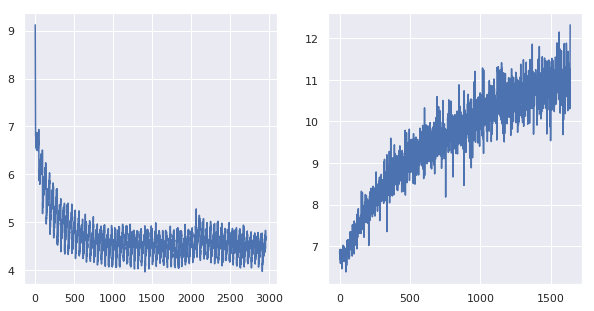

 13%|█▎        | 6/47 [00:00<00:03, 12.03it/s]


KeyboardInterrupt: 

In [15]:
hyperparams = Hyperparams(embed_size=256, hidden_size=256, num_layers=1,
                          loss_func=nn.CrossEntropyLoss,
                          learning_rate=0.03, optimizer=optim.Adam, batch_size=128)

traindataloader, valdataloader, model, optimizer, criterion = initialize_data_model_optim_loss(hyperparams)

train(100, traindataloader, valdataloader, model, criterion, optimizer)

## Results

In [25]:
for _ in range(10):
    generate_example(model)

<s> know get real ' s families was with the support the nra and . </s>
<s> i ' ve witnessed they don ' t so : end that would the many leader of them in her the things stop what my ” — @potus </s>
<s> the business interests. </s>
<s> please the " - a more college campaign , " : i think </s>
<s> join me , but you my was right , , but his , we will never be doing , look ! #makeamericagreatagain </s>
<s> many see what the inclusive the american campaign from it ' s time for is done for the american woman in donald trump in decisions to . </s>
<s> thank hillary with ! </s>
<s> it will today them . </s>
<s> you come , , join us- us , and or in the iowa , tomorrow , he didn and , ! </s>
<s> ted florida of trump in too the new ! </s>


In [32]:
torch.save(model.state_dict(), os.path.join('models', 'gru-model1.pth'))

hyperparams = Hyperparams(embed_size=256, hidden_size=256, num_layers=1,
                          loss_func='nn.CrossEntropyLoss',
                          learning_rate=0.03, optimizer='optim.Adam', batch_size=128)

with open(os.path.join('models', 'gru-model1.json'), 'w') as fout:
    json.dump(dict(hyperparams._asdict()), fout)